#Fiscal rules in the UK: Budget 2015

What would be the impact of a debt rule on the long-run fiscal position in the UK? How would it affect the rate of fiscal consolidation over this Parliament?

This workbook produces charts and data specific to the Budget 2015 report.

It uses the October 2014 Databank for historical FY data because the newer versions are prepared using ESA10 standards and are discontinuous with FSR2014.

In [1]:
import numpy as np
import pandas as pd
import pyscraper
import seaborn as sns
import matplotlib.pyplot as plt
from statsmodels.tsa.filters.hp_filter import hpfilter

from plotly.widgets import GraphWidget
from plotly.graph_objs import *
import plotly.plotly as py
import plotly.tools as tls

from IPython.display import display
from IPython.html import widgets

import json

%matplotlib inline

#Uncomment this line to replace production charts. leave commented to work in default ~jzuccollo workspace.
#py.sign_in('reformthinktank', '3eygtevagn')

:0: FutureWarning:

IPython widgets are experimental and may change in the future.



<IPython.core.display.Javascript object>

#Import data

Fiscal policy so work in fiscal years.

Need LR forecasts so:

OBR Databank (2014-2018):
 - NGDP
 - RGDP
 - Primary balance
 - PSNB
 - PSND
 
OBR FSR (2019-2063)
 - NGDP
 - RGDP
 - Primary balance
 - PSNB
 - PSND
 
##OBR Databank

In [2]:
obr_databank_pc = pd.read_excel('http://budgetresponsibility.org.uk/pubs/PSF_aggregates_databank_October-2014.xls', 'Aggregates (per cent of GDP)',
                              header=0,
                              skiprows=3,
                              skip_footer=8,
                              index_col=0,
                              parse_cols="B:H,J:N,P:Q,S:T,V:X,Z:AA",
                              na_values=["-"],
                              parse_dates=True)
obr_databank_pc.index = pd.Index(pd.date_range(start=pd.datetime(1948, 3, 31), end=pd.datetime(2018, 3, 31), freq='A-MAR'))

obr_databank_gdp_deflator = pd.read_excel('http://budgetresponsibility.org.uk/pubs/PSF_aggregates_databank_October-2014.xls', 'Aggregates (£bn)',
                              header=None,
                              skiprows=7,
                              skip_footer=6,
                              parse_cols="AB",
                              na_values=["-"])
obr_databank_gdp_deflator.index = pd.Index(pd.date_range(start=pd.datetime(1946, 3, 31), end=pd.datetime(2018, 3, 31), freq='A-MAR'))


obr_databank_pc['GDP Deflator (2013-14=100)'] = obr_databank_gdp_deflator

In [3]:
obr_databank_pc.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 71 entries, 1948-03-31 00:00:00 to 2018-03-31 00:00:00
Freq: A-MAR
Data columns (total 21 columns):
Public sector current receipts                71 non-null float64
Total managed expenditure                     71 non-null float64
Public sector current expenditure             71 non-null float64
Public sector net investment                  71 non-null float64
Depreciation                                  71 non-null float64
Public sector gross investment                71 non-null float64
Public sector net borrowing                   71 non-null float64
Cyclically-adjusted net borrowing             45 non-null float64
Current budget deficit                        71 non-null float64
Primary balance                               71 non-null float64
Cyclically-adjusted primary balance           45 non-null float64
Cyclically-adjusted current budget deficit    45 non-null float64
Public sector net debt2                       27 non-nu

##OBR Fiscal Sustainability Report

Grab central and 'low health productivity' scenarios.

In [4]:
obr_fsr_pc = pd.read_excel('http://budgetresponsibility.org.uk/pubs/FSR_2014_Supplementary_Tables.xls', '1.1',
                              header=0,
                              skiprows=3,
                              #skip_footer=8,
                              index_col=0,
                              parse_cols="B:BA",
                              na_values=["-"],
                              parse_dates=True).dropna().T
obr_fsr_pc.index = pd.Index(pd.date_range(start=pd.datetime(2013, 3, 31), end=pd.datetime(2063, 3, 31), freq='A-MAR'))

obr_fsr_pc_hp = pd.read_excel('http://budgetresponsibility.org.uk/pubs/FSR_2014_Supplementary_Tables.xls', '1.8',
                              header=0,
                              skiprows=3,
                              #skip_footer=8,
                              index_col=0,
                              parse_cols="B:BA",
                              na_values=["-"],
                              parse_dates=True).dropna().T
obr_fsr_pc_hp.index = pd.Index(pd.date_range(start=pd.datetime(2013, 3, 31), end=pd.datetime(2063, 3, 31), freq='A-MAR'))

In [5]:
obr_fsr_pc.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 51 entries, 2013-03-31 00:00:00 to 2063-03-31 00:00:00
Freq: A-MAR
Data columns (total 25 columns):
Real GDP growth                   51 non-null float64
Nominal GDP growth                51 non-null float64
Gilt rate                         51 non-null float64
Health                            51 non-null float64
Long-term care                    51 non-null float64
Education                         51 non-null float64
Pensions                          51 non-null float64
Pensioner benefits                51 non-null float64
Public service pensions           51 non-null float64
Other social benefits             51 non-null float64
Other spending                    51 non-null float64
Total non-interest spending       51 non-null float64
Income tax                        51 non-null float64
NICs                              51 non-null float64
Corporation tax                   51 non-null float64
VAT                               51 

##Bank of England database

Bank rate series. This series does not have forecasts 

In [6]:
boe_bank_rate = pyscraper.scrape.from_BoE(['IUDBEDR'], yearsback=50)

CSV retrieved from http://www.bankofengland.co.uk/boeapps/iadb/fromshowcolumns.asp?csv.x=yes&Datefrom=18/Mar/1965&Dateto=now&SeriesCodes=IUDBEDR&UsingCodes=Y&CSVF=TN&VPD=y


In [7]:
boe_bank_rate.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 10166 entries, 1975-01-02 00:00:00 to 2015-03-17 00:00:00
Data columns (total 1 columns):
IUDBEDR    10166 non-null float64
dtypes: float64(1)
memory usage: 158.8 KB


##Mung into a single dataset

Column names vary because of capitalisation and footnotes. Discard all numeric column names and convert to lower case.

In [8]:
for df in [obr_databank_pc, obr_fsr_pc, obr_fsr_pc_hp]:
    df.columns = [''.join(i.lower() for i in j.strip() if not i.isdigit()) for j in df.columns]

Patch OBR Databank values in on top of FSR values for core public spending measures.

In [9]:
lr_pusf = obr_databank_pc.combine_first(obr_fsr_pc)[['gilt rate', 'public sector net debt', 'primary balance', 'total managed expenditure', 'public sector net borrowing', 'public sector current receipts']]
lr_pusf_hp = obr_databank_pc.combine_first(obr_fsr_pc_hp)#[['public sector net debt', 'primary balance', 'total managed expenditure', 'public sector net borrowing', 'public sector current receipts']]

Construct NGDP and RGDP series from FSR's GDP growth rates.

In [10]:
fsr_lr_gdp_deflator = 0.022

gdp_seed = pd.DataFrame(obr_databank_pc['nominal gdp (£ billion)'].combine_first(obr_fsr_pc['nominal gdp growth']))
gdp_seed['gdp deflator (2013-14=100)'] = obr_databank_pc['gdp deflator (-=)']
for i, v in iter(gdp_seed['nominal gdp (£ billion)'].items()):
    if i > pd.datetime(2018, 3, 31):
        gdp_seed['nominal gdp (£ billion)'][i] = gdp_seed['nominal gdp (£ billion)'][i - pd.DateOffset(years=1)] * (1 + v/100)
        gdp_seed['gdp deflator (2013-14=100)'][i] = gdp_seed['gdp deflator (2013-14=100)'][i - pd.DateOffset(years=1)] * (1 + fsr_lr_gdp_deflator)

gdp_seed['real gdp (2013-14 pounds)'] = gdp_seed['nominal gdp (£ billion)'].div(gdp_seed['gdp deflator (2013-14=100)']).mul(100.)

lr_df = lr_pusf.join(gdp_seed).join(boe_bank_rate.resample('A-MAR', how=min))

Rename columns and merge in 'current health productivity' data to the same dataset.

In [11]:
lr_df.rename(columns={'gilt rate': 'gilt', 
              'public sector net debt': 'psnd', 
              'primary balance': 'primsurp', 
              'total managed expenditure': 'tme', 
              'public sector net borrowing': 'psnb', 
              'public sector current receipts': 'pscr', 
              'nominal gdp (£ billion)': 'ngdp', 
              'gdp deflator (2013-14=100)': 'gdp_defl', 
              'real gdp (2013-14 pounds)': 'rgdp', 
              'IUDBEDR': 'bank_rate'}, inplace=True)
lr_df[['gilt', 'psnd', 'primsurp', 'tme', 'psnb', 'pscr']] = lr_df[['gilt', 'psnd', 'primsurp', 'tme', 'psnb', 'pscr']].div(100)

lr_pusf_hp.rename(columns={'gilt rate': 'gilt', 
              'public sector net debt': 'psnd', 
              'primary balance': 'primsurp', 
              'total managed expenditure': 'tme', 
              'public sector net borrowing': 'psnb', 
              'public sector current receipts': 'pscr'}, inplace=True)
lr_pusf_hp[['psnd', 'primsurp', 'tme', 'psnb', 'pscr']] = lr_pusf_hp[['psnd', 'primsurp', 'tme', 'psnb', 'pscr']].div(100)

In [12]:
diff_cols = ['primsurp', 'tme', 'psnb', 'psnd']
lr_df = lr_df.join(lr_pusf_hp[diff_cols], rsuffix='_hp')

###Implied effective gilt rate on net debt

Calculating a path for net debt requires knowing the interest rate on all assets, along with any incidental costs and incomes. To proxy that, I use the effective gilt rate implied by the OBR forecasts. From a formula for the accumulation of debt is is possible to back out the effective, nominal gilt rate implied by the EFO and FSR.

$$i_t = \frac{(d_t - d_{t-1} + p_t)(1+\gamma_t)}{d_{t-1}} + \gamma_t$$

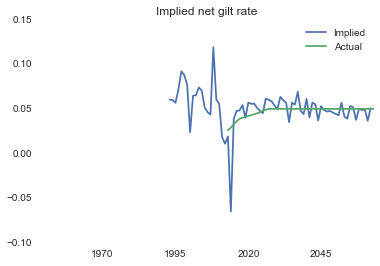

In [13]:
iegr = (lr_df['psnd'].diff() + lr_df['primsurp']).div(lr_df['psnd'].shift(-1)).mul(1 + lr_df['ngdp'].pct_change()) + lr_df['ngdp'].pct_change()
giltax = iegr.plot(title='Implied net gilt rate')
lr_df.gilt.plot(ax=giltax)
giltax.legend(['Implied', 'Actual'])

In [14]:
lr_df['eff_gilt'] = iegr

#A debt rule for the UK 

Implement a debt rule of the form $\tau_t - g_t = r d_{t-1} + f(d_{t-1} - d^*)$.

where $r$ is the real interest rate minus the growth rate of real gdp. $f$ is the adjustment rate and $d^*$ is the target level of debt. $\tau_t - g_t$ is obviously the primary surplus.

##ZLB policy

The crucial exception is that, when monetary policy is at the ZLB, fiscal policy should not follow the rule. Ideally, the OBR, HMT, and BoE would come up with an appropriate plan. Here I assume that TME continues to grow at 5%pa when the ZLB is struck, its rate of long-term growth.

When the constraint is relaxed fiscal policy can be tightened again but not so quickly as to return monetary policy to the ZLB. Without a macroeconomic model it is difficult to say how fast that is. I assume the gap between the current surplus and debt-rule surplus can be closed by 20 per cent each year.

##Cost of debt

Estimating the cost of debt from this rule is difficult because PSNB depends on the effective rate of interest on PSND. That, in turn, is affected by the dividends and interest rate on debt, which is tricky to predict. The OBR estimates the average net cost of debt to be about 3.25% over the next fifty years so that is used across all periods.

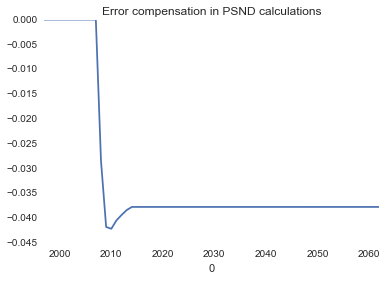

In [15]:
# Calculated error in debt projections. Probably due to bank loans.
# Saved calculated values to CSV rather than generating endogenously to avoid masking 
# future errors with endogenous error removal.
error_df = pd.read_csv("psnd_error_020215.csv", parse_dates=True, index_col=0, header=None).squeeze()
error_df.plot()
plt.title("Error compensation in PSND calculations")

In [105]:
class DebtRule():
    """
    A long-term debt rule to bring debt back to a target level at a constant, exponential rate.
    
    Takes:
        ngdp: nominal GDP
        rgdp: real GDP
        debt: Public sector net debt as a percentage of GDP (ie. 38, not 0.38)
        bank_rate: Bank of England's Bank Rate. Required for deviation from rule during ZLB (rate < 0.5%)
        prim_surp: Required if bank_rate is provided to calculate deficit at ZLB
    """
    
    def __init__(self, ngdp, rgdp, debt, tme, receipts, bank_rate, prim_surp):
        self.rgdp = rgdp
        self.ngdp = ngdp
        self.tme_pc = tme
        self.tme = self.tme_pc.mul(self.ngdp)
        self.debt_pc = debt
        self.receipts_pc = receipts
        self.receipts = self.receipts_pc.mul(self.ngdp)
        self.bank_rate = bank_rate
        self.prim_surp = prim_surp
        self.debt = self.debt_pc.mul(self.ngdp)
        self._is_zlb_bool = self._is_zlb()  # Boolean for ZLB
        self._year_lookup = self._gen_lookup_table()
        
    def _gen_lookup_table(self):
        """Generate a dictionary calculating the approach rate from the specified number of years to convergence."""
        lookup = {}
        for discount in np.linspace(0.03, 0.6, num=100):
            years = 0
            res = 1
            while res >= 0.05:  # Within 5% counts as convergence
                res = res * (1 - discount)
                years += 1
            lookup[years] = discount
        return lookup
    
    def _is_zlb(self):
        """Check if bank rate is less than 1% or GDP has fallen in current FY. Return boolean series."""
        return (self.bank_rate <= 1) | (self.rgdp.pct_change() < 0)
    
    def _zlb_surplus(self, date, debt):
        """Calculate the surplus if TME continued to grow at 5%pa."""
        psnb = (self.tme[date - pd.DateOffset(years=1)] * 1.05) - self.receipts[date]
        cost_of_debt = debt * self.gilt_rate[date]
        return -(psnb - cost_of_debt) / self.rgdp[date]
                    
    def _debt_rule(self, date, debt, psurp):
        """
        Takes scalars and returns a scalar for this year's primary surplus.
        """
        rule_val = (self.rir[date] - self.rgdp.pct_change()[date]) * debt + self.feedback * (debt - self.target_debt)
        return (1 - self._zlb_smoothing) * rule_val + self._zlb_smoothing * psurp
    
    def _debt_increment(self, date, debt, psurp):
        """
        Returns a scalar for the additional debt incurred that year.
        """
        rgdp_growth = self.rgdp.pct_change()[date]    
        lambda_t = (1 + self.rir[date]) / (1 + rgdp_growth)
        new_debt = lambda_t * debt - psurp
        return new_debt
    
    def _implied_gilt_rate(self):
        """
        Calculate the effective gilt rate from the input forecast paths.
        """
        return (self.debt_pc.diff() + self.prim_surp).div(self.debt_pc.shift(-1)).mul(1
                                                        + self.ngdp.pct_change()) + self.ngdp.pct_change()
    
    def _gdp_deflator(self):
        """
        Calculate the annual percentage growth in the GDP deflator.
        """
        return self.ngdp.div(self.rgdp).pct_change()
    
    def projections(self, date_range=pd.date_range(pd.datetime(2016, 1, 1), pd.datetime(2063, 1, 1), freq='A-MAR'),
                     target_debt=0.2, years_to_converge=50, austerity=True):
        """
        Generate the paths of the primary surplus and PSND according to the rule.
        
        Takes:
            date_range: date range of projections as pandas.date_range
            target_debt: target level of debt as a proportion of GDP (eg. 0.20)
            feedback: rate of convergence to target debt in proportion eliminated per year (eg. 0.05)
            zlb_smoothing: degree of smoothing as policy transitions from ZLB to debt convergence
            austerity: 
        """
        self.gilt_rate = self._implied_gilt_rate()
        self.rir = self.gilt_rate - self._gdp_deflator()
        self.target_debt = target_debt
        self.feedback = (self._year_lookup[years_to_converge] if years_to_converge in self._year_lookup
                else self._year_lookup[min(self._year_lookup.keys(), key=lambda k: abs(k - years_to_converge))])
        self._zlb_smoothing = 0.18 * np.log(years_to_converge)
        self._date_range = date_range
        
        pdebt = [self.debt_pc[self._date_range[0]]]
        psurp = [float('NaN')]
        for k, v in iter(self.rgdp.pct_change()[self._date_range[1:]].items()):
            if self._is_zlb_bool[k] and not austerity:
                psurp.append(self._zlb_surplus(k, pdebt[-1]))
            elif self._is_zlb_bool[k] and austerity:
                psurp.append(self.prim_surp[k])
            else:
                psurp.append(self._debt_rule(k, pdebt[-1], psurp[-1]))
            pdebt.append(self._debt_increment(k, pdebt[-1], psurp[-1]))
        
        projection = pd.DataFrame(data={'primsurp': psurp, 'psnd': pdebt}, index=self._date_range)
        try:
            projection.psnd[date_range] = projection.psnd[date_range].sub(error_df[date_range])
        except KeyError:
            pass
        return projection

In [106]:
debtrule = DebtRule(lr_df['ngdp'], 
                    lr_df['rgdp'], 
                    lr_df['psnd'],
                    lr_df['tme'],
                    lr_df['pscr'],
                    lr_df['bank_rate'],
                    lr_df['primsurp'])

In [114]:
#Define implicit parameters
proj_range=pd.date_range(pd.datetime(2014, 1, 1), pd.datetime(2064, 1, 1), freq='A-MAR')
proj = debtrule.projections(date_range=proj_range, target_debt=0.4, years_to_converge=50, austerity=True)

###What are the implications of this debt path for the major public spending areas?

Assume receipts remain as in the OBR projections and calculate the implied change in spending for each of the major areas of expenditure.

In [115]:
def interest_payments(df):
    #rule_net_interest = df['gilt rate'].div(100.).mul(proj['psnd']).mul(100.)
    implied_gilt_rate = df['net interest'].div(df['public sector net debt'])
    rule_net_interest = implied_gilt_rate.mul(proj['psnd']).mul(100.)
    fsr_net_interest = df['net interest']
    interest_diff = rule_net_interest.sub(fsr_net_interest).mul(-1.)
    return interest_diff
    

def rule_tme(incl_interest=False):
    prim_surp_diff = proj['primsurp'].sub(debtrule.prim_surp).mul(100)
    if incl_interest:
        allowed_tme = lr_df['tme'].mul(100).sub(prim_surp_diff).sub(interest_payments(obr_fsr_pc))
    else:
        allowed_tme = lr_df['tme'].mul(100).sub(prim_surp_diff)
    return allowed_tme.dropna()

In [116]:
# Create traces
x = rule_tme().index.format()
init_date = rule_tme().index[0]
trace1 = Scatter(x=x,
              y=rule_tme(incl_interest=True).values,
              name='Expenditure allowed by rule')
trace2 = Scatter(x=x,
                  y=lr_df['tme_hp'][init_date:].values * 100,
                  name='Projected expenditure (current health productivity)')
trace3 = Scatter(x=x,
              y=lr_df['tme'][init_date:].values * 100,
              name='Projected TME (high health productivity)')
trace4 = Scatter(x=x,
                  y=lr_df['pscr'][init_date:].values * 100,
                  name='Projected tax revenues')

# Aggregate traces to Data
data2 = Data([trace1, trace2, trace3, trace4])

# Create Layout
layout2 = Layout(title='Size of the state implied by the debt rule',
                 legend=Legend(),
                 yaxis=YAxis(title='Percentage of GDP'))

# Create Figure
fig2 = Figure(data=data2, layout=layout2)

url = py.plot(fig2, filename='size_of_state', auto_open=False)
tls.embed(url)

In [117]:
# Aggregate traces to Data
data = Data([Bar(x=interest_payments(obr_fsr_pc_hp).dropna().index.format(),
                 y=interest_payments(obr_fsr_pc_hp).dropna().values,
                name='Relative to current health productivity scenario'),
            Bar(x=interest_payments(obr_fsr_pc).dropna().index.format(),
                 y=interest_payments(obr_fsr_pc).dropna().values,
                name='Relative to high health productivity scenario')])

# Create Layout
layout = Layout(title='Annual saving in debt interest repayments',
                 yaxis=YAxis(title='Percentage of GDP'))

# Create Figure
fig = Figure(data=data, layout=layout)

url = py.plot(fig, filename='debt_interest', auto_open=False)
tls.embed(url)

In [118]:
np.npv(0.05, interest_payments(obr_fsr_pc_hp).dropna().values)

8.9143645177614346

In [23]:
obr_fsr_pc_hp.iloc[-1, :].div(obr_fsr_pc_hp.iloc[0, :]).order(ascending=False)

net interest                      4.777778
public sector net borrowing       2.793103
public sector net debt            2.733333
gilt rate                         1.923077
long-term care                    1.916667
primary balance                   1.900000
health                            1.822785
capital taxes                     1.538462
pensions                          1.362069
total managed expenditure         1.259770
total non-interest spending       1.111111
income tax                        1.105263
real gdp growth                   1.086957
total non-interest revenue        1.024658
public sector current receipts    1.023873
nics                              1.000000
nominal gdp growth                1.000000
vat                               0.969231
other taxes                       0.961538
other social benefits             0.913793
pensioner benefits                0.900000
corporation tax                   0.875000
education                         0.792453
other spend

In [119]:
# Create traces
x = obr_fsr_pc_hp['2015-3-1':'2062-6-1'].index.format()
trace1 = Scatter(x=x,
              y=obr_fsr_pc_hp[['education']].sum(axis=1)['2015-3-1':'2062-6-1'].values,
              name='Education',
                fill='tozeroy')
trace2 = Scatter(x=x,
                  y=obr_fsr_pc_hp[['education', 'pensions', 'pensioner benefits']].sum(axis=1)['2015-3-1':'2062-6-1'].values,
                  name='Pensions and pensioner benefits',
                fill='tonexty')
trace3 = Scatter(x=x,
              y=obr_fsr_pc_hp[['health', 'long-term care', 'pensions', 'pensioner benefits', 'education']].sum(axis=1)['2015-3-1':'2062-6-1'].values,
              name='Health and long-term care',
                fill='tonexty')
trace4 = Scatter(x=rule_tme(incl_interest=True).index.format(),
                  y=rule_tme(incl_interest=True).values,
                  name='Other spending within debt rule',
                fill='tonexty')

# Aggregate traces to Data
data2 = Data([trace1, trace2, trace3, trace4])

# Create Layout
layout2 = Layout(title='Implications of spending protections for the public finances',
                 legend=Legend(),
                 yaxis=YAxis(title='Percentage of GDP'))

# Create Figure
fig2 = Figure(data=data2, layout=layout2)

url = py.plot(fig2, filename='tme_breakdown', auto_open=False)
tls.embed(url)

In [25]:
mytmpser = rule_tme(incl_interest=True).sub(obr_fsr_pc_hp[['health', 'long-term care', 'pensions', 'pensioner benefits', 'education']].sum(axis=1))
print("The cut in 'other expenditure' from peak to 2063 will be {:.0f} per cent".format(100 * (1 - mytmpser.iloc[-2] / mytmpser.iloc[2])))

The cut in 'other expenditure' from peak to 2063 will be 54 per cent


##Plotly interactive

In [120]:
def plotly_results(year_from=2007, year_to=2063, target_debt=0.2, years_to_converge=50, austerity=True):
    """
    Generate plots of primary surplus and debt, given parameters. Used in interaction below.
    """
    
    #Define implicit parameters
    proj_range=pd.date_range(pd.datetime(year_from, 1, 1), pd.datetime(year_to, 1, 1), freq='A-MAR')
    
    #Set up the projections and plots
    proj = debtrule.projections(date_range=proj_range, target_debt=target_debt, years_to_converge=years_to_converge, austerity=austerity)
    
    #Plot it
    init_date = proj_range[0]
    # Create traces
    x = proj.index.format()
    trace1 = Bar(x=x,
                  y=proj['primsurp'].values,
                  name='Rule-based primary surplus')
    trace2 = Scatter(x=x,
                      y=proj['psnd'].values * 100,
                      name='Rule-based government debt',
                      mode='lines',
                      yaxis='y2',
                      line=Line(shape='spline'))
    trace3 = Bar(x=x,
                  y=lr_df['primsurp'][init_date:].values,
                  name='Actual/forecast surplus (high health productivity)',
                  opacity=0.3)
    trace4 = Scatter(x=x,
                      y=lr_df['psnd'][init_date:].values * 100,
                      name='Actual/forecast debt (high health productivity)',
                      mode='lines',
                      yaxis='y2',
                      opacity=0.3,
                      line=Line(shape='spline'))
    trace5 = Bar(x=x,
                  y=lr_df['primsurp_hp'][init_date:].values,
                  name='Actual/forecast surplus (current health productivity)',
                  opacity=0.3)
    trace6 = Scatter(x=x,
                      y=lr_df['psnd_hp'][init_date:].values * 100,
                      name='Actual/forecast debt (current health productivity)',
                      mode='lines',
                      yaxis='y2',
                      opacity=0.3,
                      line=Line(shape='spline'))

    # Aggregate traces to Data
    data1 = Data([trace1, trace3, trace2, trace4, trace5, trace6])
    
    # Create Layout
    layout1 = Layout(title='Rule-based public Finances',
                     legend=Legend(traceorder='reversed'),
                     yaxis=YAxis(domain=[0, 0.45], title='Percentage of GDP'),
                     yaxis2=YAxis(domain=[0.55, 1], title='Percentage of GDP'))
    
    # Create Figure
    return Figure(data=data1, layout=layout1)

fig1 = plotly_results()
url = py.plot(fig1, filename='debt_rule', auto_open=False)

In [30]:
g = GraphWidget(url)

target_debt_w = widgets.FloatSlider(min=10, max=80, step=2, value=40, description='Target debt')
feedback_w = widgets.FloatSlider(min=5, max=100, step=2, value=50, description='Years to convergence')

my_widgets = [target_debt_w, feedback_w]

def regraph():
    proj_range = pd.date_range(pd.datetime(2007, 1, 1), pd.datetime(2063, 1, 1), freq='A-MAR')
    new_data = debtrule.projections(date_range=proj_range, target_debt=target_debt_w.value/100, years_to_converge=feedback_w.value)
    new_data.fillna(0, inplace=True)
    x = new_data.index.format()
    g.restyle({'x': [x, x], 'y': [new_data['primsurp'].values, new_data['psnd'].values]}, indices=[0, 2])
    
    
for w in my_widgets:
    w.on_trait_change(regraph, 'value')
    display(w)

display(g)

##Generate all values and write to json

In [123]:
def build_chart_data(target_debt, years_allowed):
    proj_range = pd.date_range(pd.datetime(2007, 1, 1), pd.datetime(2063, 1, 1), freq='A-MAR')
    projections = debtrule.projections(date_range=proj_range, target_debt=target_debt / 100, 
                             years_to_converge=years_allowed)
    projections.columns = ['primsurp_rule', 'psnd_rule']
    init_date = proj_range[0]
    
    static_df = pd.concat([lr_df['primsurp'][init_date:],
                    lr_df['psnd'][init_date:],
                    lr_df['primsurp_hp'][init_date:],
                    lr_df['psnd_hp'][init_date:]], join='outer', axis=1)
    static_df.columns = ['primsurp_static_highprod',
                        'psnd_static_highprod',
                        'primsurp_static_currprod',
                        'psnd_static_currprod']
    return projections.join(static_df)


results = {}
results["variable1"] = "Target debt level (per cent of GDP)"
results["default_value"] = 40
results["values"] = {}
for target_debt in range(10, 80, 5):
    results["values"][target_debt] = {}
    results["values"][target_debt]["variable2"] = "Years until target must be achieved"
    results["values"][target_debt]["default_value"] = 50
    results["values"][target_debt]["values"] = {}
    for years_allowed in range(5, 100, 5):
        new_data = build_chart_data(target_debt, years_allowed)
        results["values"][target_debt]["values"][years_allowed] = json.loads(new_data.to_json(orient='split'))
        results["values"][target_debt]["values"][years_allowed]['y_label'] = ['Primary surplus (per cent of GDP)',
                                                                             'Net debt (per cent of GDP)',
                                                                             'Primary surplus (per cent of GDP)',
                                                                             'Net debt (per cent of GDP)',
                                                                             'Primary surplus (per cent of GDP)',
                                                                             'Net debt (per cent of GDP)']
        results["values"][target_debt]["values"][years_allowed]['x_label'] = ['Year',
                                                                             'Year',
                                                                             'Year',
                                                                             'Year',
                                                                             'Year',
                                                                             'Year']
        results["values"][target_debt]["values"][years_allowed]['long_names'] = ['Rule-based primary surplus',
                                                                                'Rule-based net debt',
                                                                                'Actual/forecast surplus (high health productivity)',
                                                                                'Actual/forecast debt (high health productivity)',
                                                                                'Actual/forecast surplus (current health productivity)',
                                                                                'Actual/forecast debt (current health productivity)']

__Uncomment below to overwrite the JSON results dump. Also needs to be updated in the Wordpress to show up on the production charts.__

In [124]:
with open("results.json","w") as f:
    json.dump(results, f)

In [125]:
results

{'default_value': 40,
 'values': {10: {'default_value': 50,
   'values': {5: {'columns': ['primsurp_rule',
      'psnd_rule',
      'primsurp_static_highprod',
      'psnd_static_highprod',
      'primsurp_static_currprod',
      'psnd_static_currprod'],
     'data': [[None, 0.367, -0.011, 0.367, -0.011, 0.367],
      [-0.051, 0.49, -0.051, 0.49, -0.051, 0.49],
      [-0.088, 0.62, -0.088, 0.62, -0.088, 0.62],
      [-0.063, 0.687, -0.063, 0.687, -0.063, 0.687],
      [-0.047, 0.723, -0.047, 0.723, -0.047, 0.723],
      [-0.053, 0.768, -0.053, 0.768, -0.053, 0.768],
      [-0.039, 0.79, -0.039, 0.79, -0.039, 0.79],
      [-0.029, 0.773, -0.029, 0.773, -0.029, 0.773],
      [-0.014, 0.7872624683, -0.014, 0.787, -0.014, 0.787],
      [0.2392120928, 0.5494165103, 0.005, 0.783, 0.005, 0.783],
      [0.2240528111, 0.3270142839, 0.02, 0.765, 0.02, 0.765],
      [0.1377101467, 0.1923472446, 0.03, 0.742, 0.03, 0.742],
      [0.0596433723, 0.1318660888, 0.028, 0.71, 0.027, 0.72],
      [0.01584